In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

# Manual Selection (Not Feasible)

### Drop & why
- connection_time (88% zeros, low correlation)
-
### KEEP
- protocol
- service_type
- connection_status
- source_bytes
- destination_bytes
- suspicious_activity ----------------------------
- compromised_count
- guest_login
-

In [3]:
df = pd.read_csv("../data/original/raw_data.csv")

In [4]:
## Feature Engineering

X = df[list(set(df.columns) - {"class"})]
y = df["class"].replace({"normal": 0, "anomaly": 1})

# Numeric Features
X_numeric = df[[col for col in df.columns if df[col].dtype != "O"]]
numeric_feature_names = X_numeric.columns
X_numeric = X_numeric.to_numpy()

# All features
df_encoded = pd.get_dummies(X).replace({False: 0, True: 1})
feature_names = pd.Series(df_encoded.columns)
X = df_encoded.to_numpy()

X.shape

(14036, 102)

In [39]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alpha_values = np.arange(0, 1, 0.001)


def try_alpha(alpha):
    lasso = Lasso(alpha=alpha, random_state=0)
    lasso.fit(X_scaled, y)

    features = feature_names
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Coefficient': lasso.coef_
    })

    # Features with non-zero coefficients are selected
    selected_features = feature_importance[feature_importance['Coefficient'] != 0]

    if len(selected_features) == 0:  # extreme regularization = no features are selected, break the loop
        return None

    x_final = df_encoded[selected_features["Feature"]].to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.33, random_state=42)

    clf = LogisticRegression(random_state=0).fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    f1_result = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return f1_result, recall


results = Parallel(n_jobs=-1)(delayed(try_alpha)(alpha) for alpha in alpha_values)

In [40]:
f1_results = [record[0] for record in results if record is not None]
recall_results = [record[1] for record in results if record is not None]
alpha_values = alpha_values[:len(f1_results)]

<Axes: >

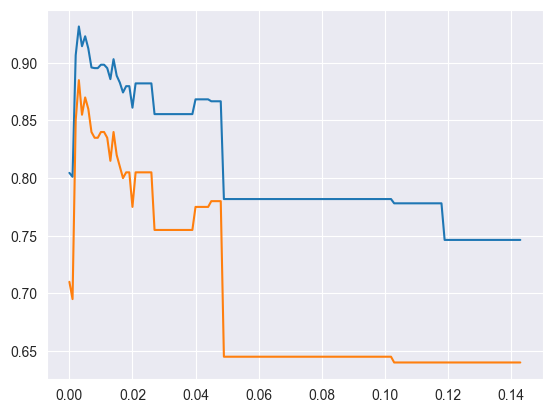

In [41]:
sns.lineplot(x=alpha_values, y=f1_results)
sns.lineplot(x=alpha_values, y=recall_results)

In [43]:
best_alpha = alpha_values[np.argsort(f1_results)[-1]]
best_alpha = round(best_alpha, 5)

print("Best Alpha Value =", best_alpha)
print("Included Numeric Features = ", 27 - len(set(numeric_feature_names) - set(selected_features["Feature"])))

Best Alpha Value = 0.003
Included Numeric Features =  17


In [44]:
lasso = Lasso(alpha=best_alpha, random_state=0)
lasso.fit(X_scaled, y)

features = feature_names
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': lasso.coef_
})

# Features with non-zero coefficients are selected
selected_features = feature_importance[feature_importance['Coefficient'] != 0]
selected_features

,Feature,Coefficient
2,connection_count,0.043246
3,destination_server_reset_error_rate,0.007082
5,destination_host_count,0.000755
6,reset_error_rate,0.003042
9,destination_different_server_rate,0.016256
...,...,...
94,service_type_telnet,-0.004606
97,service_type_urp_i,-0.005846
98,service_type_uucp,0.001529
99,service_type_uucp_path,0.005487


In [45]:
d = selected_features.set_index("Feature").T
d = d[selected_features["Feature"]].T.reset_index()
d["Coefficient"] = d["Coefficient"].apply(abs)
d.sort_values(by="Coefficient", ascending=False).reset_index(drop=True).head(20)

,Feature,Coefficient
0,same_server_rate,0.050778
1,destination_server_syn_error_rate,0.046726
2,connection_count,0.043246
3,service_type_private,0.025242
4,service_type_eco_i,0.023159
5,connection_status_S0,0.023130
6,protocol_udp,0.022462
7,connection_status_RSTR,0.019803
8,server_syn_error_rate,0.019750
9,different_server_rate,0.018833


In [49]:
f_names = list(d["Feature"])
filtered = df_encoded[f_names].copy()
filtered.loc[:, 'class'] = df['class']
filtered.to_csv("data/original/LASSO_selected_features.csv", index=False)
filtered

,connection_count,destination_server_reset_error_rate,destination_host_count,reset_error_rate,destination_different_server_rate,destination_server_syn_error_rate,destination_server_different_host_rate,server_syn_error_rate,destination_reset_error_rate,server_request_count,...,service_type_ssh,service_type_sunrpc,service_type_supdup,service_type_systat,service_type_telnet,service_type_urp_i,service_type_uucp,service_type_uucp_path,service_type_vmnet,class
0,2,0.01,87,0.0,0.00,0.0,0.00,0.00,0.01,2,...,0,0,0,0,0,0,0,0,0,anomaly
1,242,0.00,255,0.0,0.07,1.0,0.00,1.00,0.00,6,...,0,0,0,0,0,0,0,0,0,anomaly
2,234,0.00,255,0.0,0.08,1.0,0.00,1.00,0.00,16,...,0,0,0,0,0,0,0,0,0,anomaly
3,140,0.00,255,0.0,0.08,1.0,0.00,1.00,0.00,1,...,0,0,0,0,0,0,0,0,0,anomaly
4,126,0.00,255,0.0,0.07,1.0,0.00,1.00,0.00,11,...,0,0,0,0,0,0,0,0,0,anomaly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14031,1,0.00,58,0.0,0.07,0.0,0.07,0.00,0.00,1,...,0,0,0,0,0,0,0,0,0,normal
14032,19,0.00,255,0.0,0.00,0.0,0.00,0.00,0.00,19,...,0,0,0,0,0,0,0,0,0,normal
14033,1,0.10,255,0.0,0.02,0.0,0.00,0.00,0.03,1,...,0,0,0,0,0,0,0,0,0,normal
14034,1,0.00,12,0.0,0.17,0.0,0.00,0.00,0.00,3,...,0,0,0,0,0,0,0,0,0,normal
